In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import random
from sklearn.metrics import r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Data loading from GDrive

In [ ]:
file_path = '/content/drive/MyDrive/FluidsData/FluidData/{i}.csv'
features = []

for i in range(1,33):
  data = pd.read_csv('/content/drive/MyDrive/FluidsData/FluidData/{}.csv'.format(i))['U:0']
  features.append(np.array(data))

In [ ]:
features  = np.array(features)
features.shape

(32, 1001)

## Creating labels/target grid of images as per mentioned in the paper

In [ ]:
img = np.zeros((800,800), dtype = np.uint8)

beta = 1.0/80.0
rad = []
finalset = []

for i in range(1, 33):
    img2 = np.zeros((40,40), dtype = np.uint8)
    radius = int(i * (800.0 * beta)*(1.0/2.0))
    rad.append(radius)
    img = cv2.circle(img, (400,400), radius, 255, -1)
    for a in range(40):
        for b in range(40):
            x = a * 20;
            y = b * 20;
            sum = 0.0
            for i in range(20):
                for j in range(20):
                    sum += img[x+i, y+j];
            sum /= 400.0;
            img2[a, b] = sum
    finalset.append(img2)
    cv2.waitKey(0)

print('X_data shape:', np.array(finalset).shape)
rad = np.array(rad)

X_data shape: (32, 40, 40)


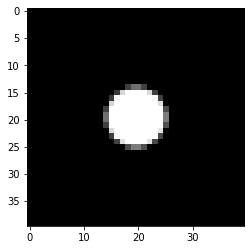

In [ ]:
plt.imshow(finalset[21],cmap='gray')  #eg of the above creation

## Creating custom dataset so that we can feed it in our ANN

In [ ]:
labels = []
yset = []
for i in range(32):
  tlf  = finalset[i].reshape(-1)/255
  yset.append(tlf)
  labels.append(np.where(tlf<0.35,0,1))

labels = np.array(labels)
yset = np.array(yset)
print(labels.shape)

(32, 1600)


In [ ]:
# idx = list(range(32))
# #idx = random.sample(idx,32)
# #len(set(idx))
# below lsit can be obtianed through above code
idx = [29, 21,  0, 20, 25, 30, 23, 10,  2,  4, 11,  8,  9, 18, 27, 15,  7, 24, 17,  3, 14,  5, 22, 13, 16, 28,  6, 26, 31,  1, 19, 12] # so that we can randomly distribute the data
#len(set(idx))  # if we use random.randint to iterate the every time we run we get different result so to get constant result we already define the list

X_train,y_train,plottrain = features[idx[:26]],labels[idx[:26]],yset[idx[:26]]
X_val,y_val,plotval = features[idx[26:30]],labels[idx[26:30]],yset[idx[26:30]]
X_test,y_test,plottest = features[idx[30:32]],labels[idx[30:32]],yset[idx[30:32]]
ytestrad = rad[idx[30:32]]

## Training our model

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Dense(256,input_shape=(1001,)),
                             tf.keras.layers.Dense(256,activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512,activation='relu'),
                             tf.keras.layers.Dense(512,activation='relu'),
                             tf.keras.layers.Dense(1600,activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(X_train,y_train,epochs=150)

Epoch 1/150
1/1 [==============================] - 1s 617ms/step - loss: 0.7173 - binary_accuracy: 0.4885
Epoch 2/150
1/1 [==============================] - 0s 21ms/step - loss: 0.6355 - binary_accuracy: 0.6754
Epoch 3/150
1/1 [==============================] - 0s 20ms/step - loss: 0.4635 - binary_accuracy: 0.8179
Epoch 4/150
1/1 [==============================] - 0s 24ms/step - loss: 0.2655 - binary_accuracy: 0.8972
Epoch 5/150
1/1 [==============================] - 0s 20ms/step - loss: 0.1623 - binary_accuracy: 0.9434
Epoch 6/150
1/1 [==============================] - 0s 31ms/step - loss: 0.1177 - binary_accuracy: 0.9623
Epoch 7/150
1/1 [==============================] - 0s 27ms/step - loss: 0.0996 - binary_accuracy: 0.9641
Epoch 8/150
1/1 [==============================] - 0s 26ms/step - loss: 0.0995 - binary_accuracy: 0.9584
Epoch 9/150
1/1 [==============================] - 0s 27ms/step - loss: 0.0988 - binary_accuracy: 0.9556
Epoch 10/150
1/1 [==============================] - 0s

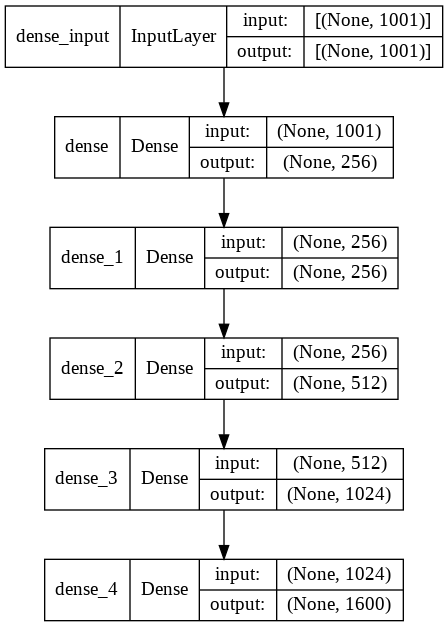

In [ ]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, expand_nested=True) #How our model actually looks

## Evaluation and prediction part

In [ ]:
model.evaluate(X_val,y_val)

1/1 [==============================] - 0s 142ms/step - loss: 0.1566 - binary_accuracy: 0.9720


[0.15657612681388855, 0.9720312356948853]

In [ ]:
predictions = model.predict(X_test)

## Plotting the real ad the predicted image of the obstacle

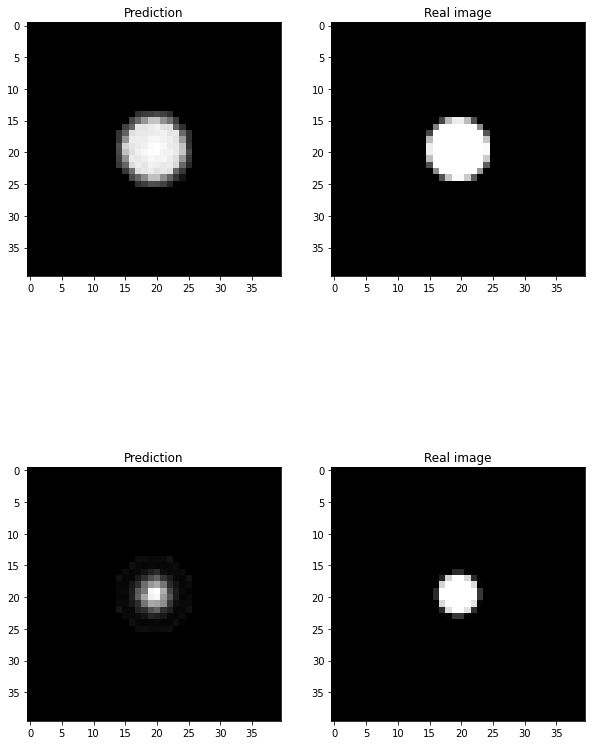

In [ ]:
plt.rcParams["figure.figsize"] = (10,15)
fig,ax = plt.subplots(2,2)
for i in range(2):
  ax[i,0].imshow(predictions[i].reshape(40,40),cmap='gray')
  ax[i,0].set_title('Prediction')
  ax[i,1].imshow(plottest[i].reshape(40,40),cmap='gray')
  ax[i,1].set_title('Real image')

plt.show()

## calcualting the R_2 metrics of the predicted images as per mentioned in paper

In [ ]:
R2_score = []
for i in range(2):
  R2_score.append(r2_score(predictions[i], y_test[i]))
  print('R2 Score for the test {} is {}'.format(i+1,r2_score(predictions[i], y_test[i])))

R2 Score for the test 1 is 0.8703673972972206
R2 Score for the test 2 is -0.5499289444370488


Text(0, 0.5, 'R2 wrt radius')

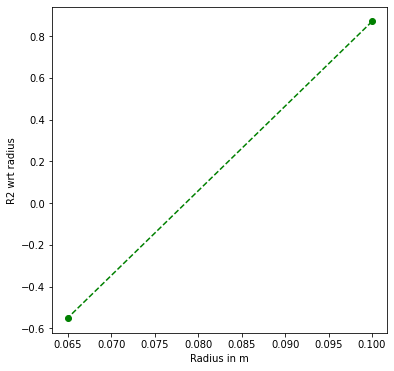

In [ ]:
plt.plot(ytestrad/1000,R2_score,'go--')
plt.xlabel('Radius in m')
plt.ylabel('R2 wrt radius')

## Main part calcualting the area and the size/radius of the obstacles

In [ ]:
mes = []
for i in predictions:
  a = i.reshape(40,40)*255
  mes.append(np.where(a<35,0,1))

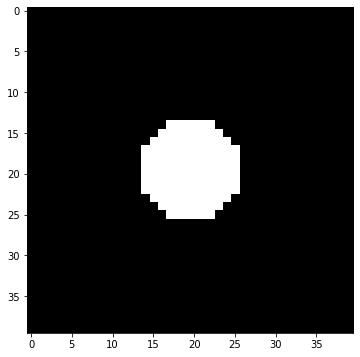

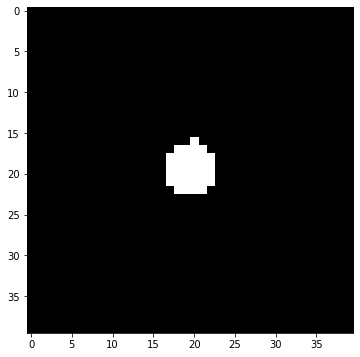

In [ ]:
plt.rcParams["figure.figsize"] = (6,6)
plt.imshow(mes[0],cmap='gray')
plt.show()
plt.imshow(mes[1],cmap='gray')
plt.show()

In [ ]:
def find_area_rad(img):
  img = img.astype(np.uint8)*255
  ret,thresh = cv2.threshold(img,36,255,cv2.THRESH_BINARY)
  #thresh = thresh.astype('uint8')
  contours,hierarchy = cv2.findContours(thresh, 1, 2)
  cnt = contours[0]

  return  cv2.contourArea(cnt) , np.sqrt(cv2.contourArea(cnt)/np.pi)

In [ ]:
area_pred0,rad_pred0 = find_area_rad(mes[0])
area_pred1,rad_pred1 = find_area_rad(mes[1])
area_true0,rad_true0 = find_area_rad(y_test[0].reshape(40,40))
area_true1,rad_true1 = find_area_rad(y_test[1].reshape(40,40))

In [ ]:
print('Radius for true image : {} and radius for the predicted image {} for test image {}'.format(rad_true0,rad_pred0,1))
print('Radius for true image : {} and radius for the predicted image {} for test image {}'.format(rad_true1,rad_pred1,2))

Radius for true image : 4.61809077155419 and radius for the predicted image 5.725898905580716 for test image 1
Radius for true image : 2.7057581899030048 and radius for the predicted image 2.763953195770684 for test image 2
